# Preprocessing EEG with MNE

**Authors**:

 - Mercedes Riveira mercedesriveira97@gmail.com | [@MercedesRiveira [in]](https://www.linkedin.com/in/mercedes-riveira-martin/)
 - Borja Sánchez Leirado borja.sanchez.leirado@gmail.com | [@BorjaSanchez [in]](https://www.linkedin.com/in/borjasanlei/)

---

_This code is Open Source, released under a GPL License._

In [3]:
import mne
import pandas as pd
import numpy as np

%matplotlib inline

In [4]:
#This import is only for making bigger plots. It can be removed.
import matplotlib 
matplotlib.rcParams['figure.figsize'] = [12, 6]

We will be following the [preprocessing steps suggested by Mike X. Cohen](https://www.youtube.com/watch?v=JMB9nZNGVyk) and [MNE tutorials](https://mne.tools/stable/auto_tutorials/index.html).

## Loading Bitbrain's .CSV EEG into a Pandas dataframe

We follow [**session0-importing-bitbrain-data-into-mne**](./session0-importing-bitbrain-data-into-mne.ipynb) to generate `mne.io.raw` object with EEG data.

In [5]:
'''Loading data'''
df = pd.read_csv("data/02-08-2020-jv-baseline-activity-no-labels-BBT-E16-AAA005-2020-02-08_12-59-21/EEG.csv")
df_mne = df.drop(['timestamp', 'sequence', 'battery', 'flags'], axis=1)

'''Transpose'''
data_mne = df_mne.to_numpy().transpose()

'''Scale'''
data_mne = data_mne / 1000000

'''Raw info'''
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz']
info_mne = mne.create_info(
    #ch_names=list(df_mne.columns),
    ch_names=channels,
    ch_types='eeg',
    sfreq=256)

bbt_raw = mne.io.RawArray(data_mne, info_mne)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

'''Final Raw object'''
raw_1020 = bbt_raw.copy().set_montage(ten_twenty_montage)

Creating RawArray with float64 data, n_channels=16, n_times=60712
    Range : 0 ... 60711 =      0.000 ...   237.152 secs
Ready.
DigMontage is a superset of info. 78 in DigMontage will be ignored. The ignored channels are: {'AFz', 'F9', 'O9', 'TP10', 'F7', 'A1', 'AF3', 'T5', 'FC5', 'AF5', 'AF8', 'AF7', 'AF10', 'P7', 'F5', 'TP9', 'FT9', 'Fz', 'FC3', 'CP6', 'P3', 'T8', 'T6', 'T3', 'FT8', 'C6', 'AF4', 'F6', 'FCz', 'TP8', 'PO4', 'T10', 'CPz', 'P8', 'PO5', 'P9', 'PO1', 'M2', 'AF6', 'T9', 'AF9', 'F1', 'P6', 'AF2', 'P10', 'Iz', 'F2', 'FT10', 'PO3', 'CP5', 'Fpz', 'PO9', 'T4', 'PO7', 'PO8', 'P5', 'AF1', 'FT7', 'FC4', 'Oz', 'FC6', 'A2', 'PO6', 'T7', 'F10', 'P4', 'C5', 'P2', 'POz', 'M1', 'PO2', 'FC2', 'O10', 'F8', 'TP7', 'PO10', 'FC1', 'P1'}


In [6]:
raw_1020

<RawArray  |  None, n_channels x n_times : 16 x 60712 (237.2 sec), ~7.5 MB, data loaded>

## Plotting our imported MNE data

Let's analyze the quality of our data. This EEG was recorded on a subject for connectivity and transmission tests, so no special events were recorded. We will focus only on cleanning data.

In data analysis, plotting data is the very first step we need to perform, to get an idea and look for systematic errors.

We cleay see how impedance is slowly changing over time and thus average voltages are increasing slowly.

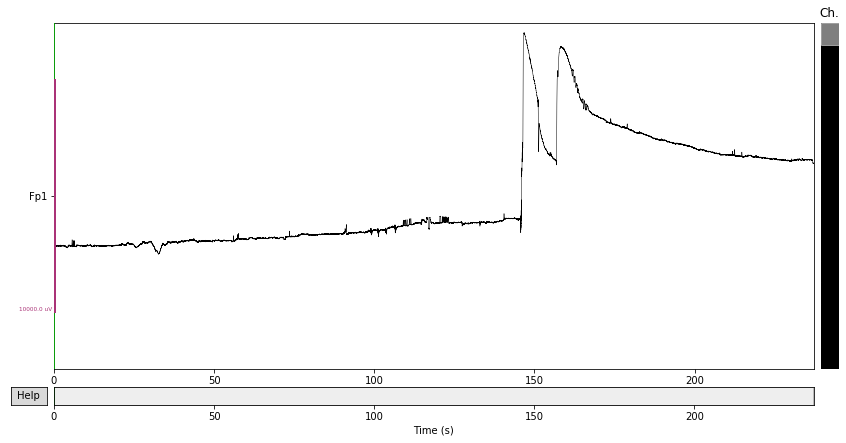

In [7]:
pEEG = raw_1020.plot(start = 0., duration = 250., scalings=0.5e-2, remove_dc=True, n_channels=1)

We do not notice any missworking electrode.

## High/low-pass filters and notches

Large changes are important when the hole measurement is analyzed.

To remove these non-brain-related slow changes we perform some filtering. The same technique is applied for frequencies higher than those emitted by the brain.

This is the full spectrogram of the raw data, for each channel. It's performed using the _Welch's method_.

Effective window size : 8.000 (s)


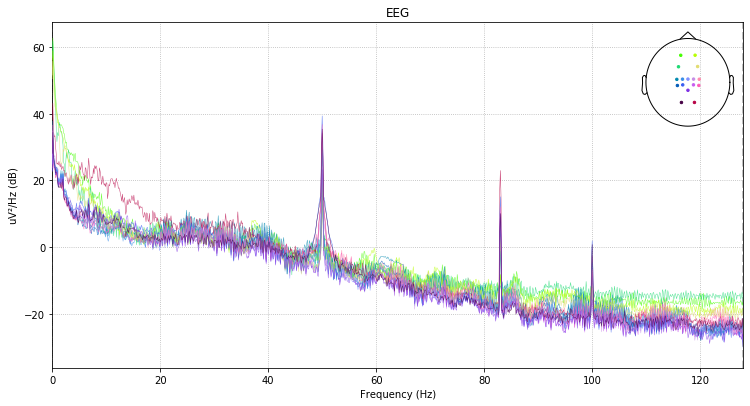

In [8]:
fig = raw_1020.plot_psd(fmin = 0, fmax = 200, average=False, tmin = 0, tmax = 250)

We apply the filters.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 sec)

Effective window size : 8.000 (s)


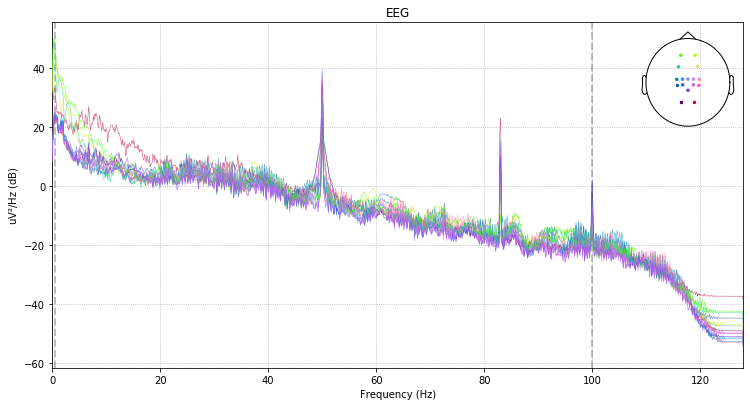

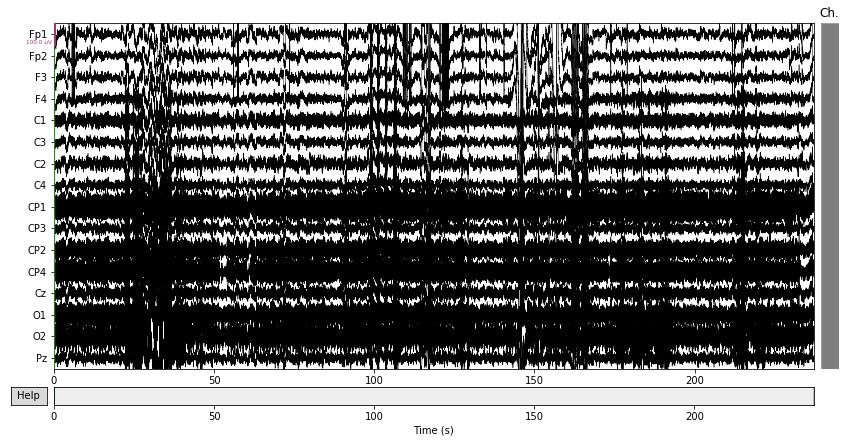

In [9]:
'''High/low-pass'''

fmin, fmax = 0.5, 100

raw_1020.filter(l_freq = fmin, h_freq = fmax, )
powerEEG = raw_1020.plot_psd(fmin = 0, fmax = 200, average=False, tmin = 0, tmax = 250)
timeEEG = raw_1020.plot(start = 0., duration = 250., scalings=0.5e-4, remove_dc=True)

Also there are some fixed frequencies related to electromagnetic noise. For instance, the very intense peak at `50Hz` (and it's harmonic at `100Hz`) is corresponded with the power-line diploe emission.

We filter that using a notch filter.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 sec)

Effective window size : 8.000 (s)


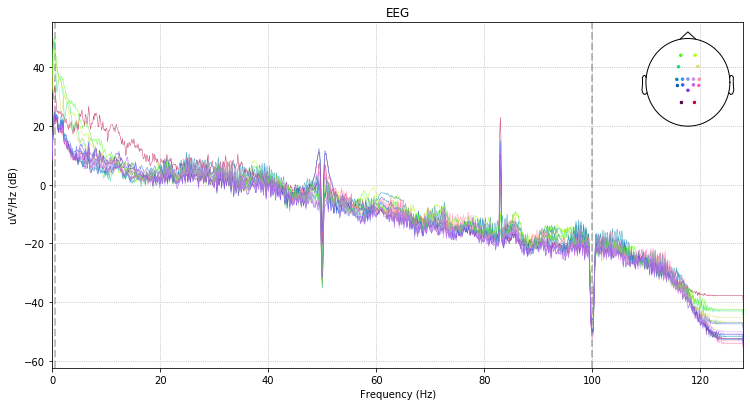

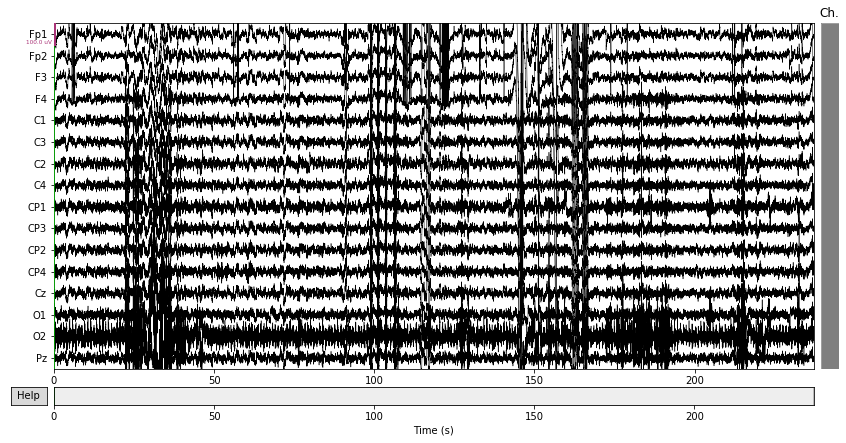

In [10]:
'''Notch at 50 Hz'''
pl_freq = 50. #Power-line freq (Spain = 50Hz)
ny_freq = 128. #Nyquist freq 

raw_1020.notch_filter(np.arange(pl_freq, ny_freq, pl_freq), fir_design='firwin')
powerEEG = raw_1020.plot_psd(fmin = 0, fmax = 200, average=False, tmin = 0, tmax = 250)
timeEEG = raw_1020.plot(start = 0., duration = 250., scalings=0.5e-4, remove_dc=True)

## Bad electrodes

Bad electrodes can be spotted visually. It's recommended to throw the measured values and interpolate using the closer electrodes.

Let's say that electrode `O2` is not working properly. We could interpolate it using `O1` (the only one close enough). In this case it's recommended to mark `O2` as a _bad channel_.

In [11]:
raw_1020.info['bads'] = ['O2']

In [12]:
print(raw_1020.info['bads'])

['O2']


_Bad channels_ are marked in grey.

#### Interpolating bad electrodes

In [13]:
eeg_data_interp = raw_1020.copy().interpolate_bads(reset_bads=False)

Computing interpolation matrix from 15 sensor positions
Interpolating 1 sensors


Here we see original _bad channel_ (`O2` in grey).

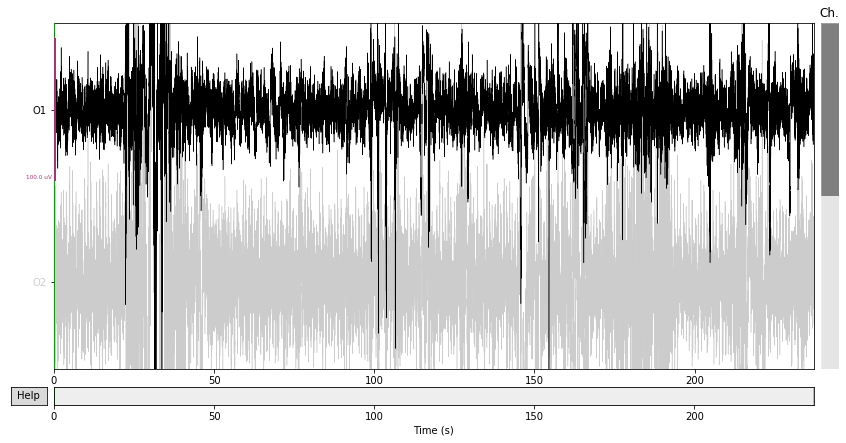

In [14]:
picks = mne.pick_channels_regexp(raw_1020.info['ch_names'], 'O.')
timeEEG = raw_1020.plot(start = 0., duration = 250., scalings=0.5e-4,
                        order = picks, n_channels = len(picks))

And this is the _interpolated channel_. You can see it's almos identical to `O1`, because it's the only occipital electrode.

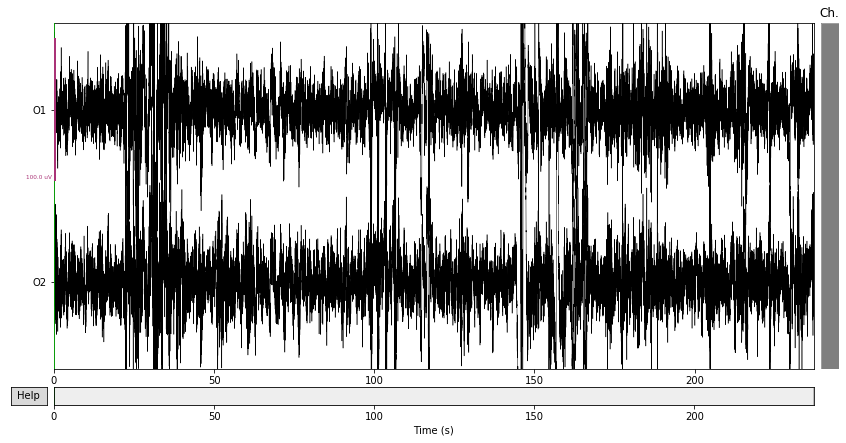

In [15]:
eeg_data_interp.info['bads'] = []
timeEEG = eeg_data_interp.plot(start = 0., duration = 250., scalings=0.5e-4,
                        order = picks, n_channels = len(picks))


## Reference EOG, EKG, EMG

Brain is not a unique source of electric activity on the body. Hearbeat, muscle contraction and others introduce peridoic noise. These activities can be recorded simultaneusly and can be used to remove their induced artifacts.

## Epoch around events

EEG is often used to take advantage of it's time resolution and to measure _Evoked Potentials_ wich are the response of the brain to external stimuli.

By a _epoch_ we refer to certain window of time after and before one event. Typically more than one event is recorded. We 'cut' in epochs, and create a 3D object with one dimension the voltage, one dimension the time (with the event at 0, and duration the time window), and the third dimension the epoch. 

For this purpose, we need a _STIM_ channel to record the stimuli. This is not the case, but a complete guide can be found [here](https://mne.tools/stable/auto_tutorials/intro/plot_20_events_from_raw.html#sphx-glr-auto-tutorials-intro-plot-20-events-from-raw-py).


For paradigms that are not event-related (e.g., analysis of resting-state data), you can extract regularly spaced (possibly overlapping) spans of data by creating events using `mne.make_fixed_length_events()` and then proceeding with epoching.

In [16]:
events = mne.make_fixed_length_events(raw_1020, id = 333, duration = 1.)

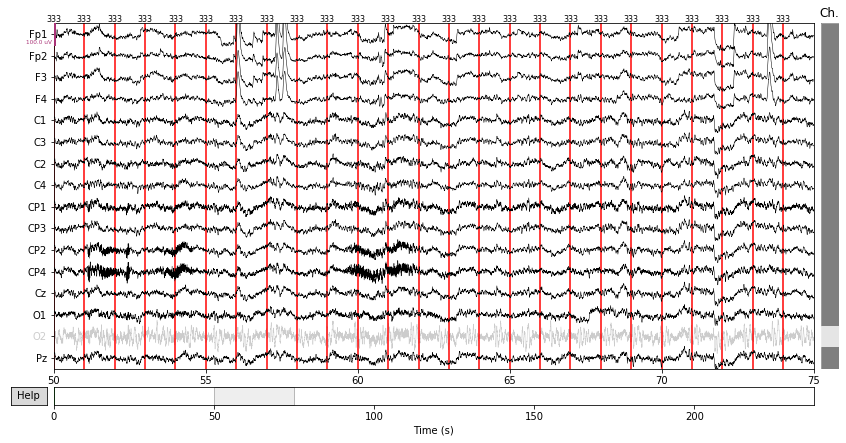

In [17]:
fig = raw_1020.plot(start = 50., duration = 25., scalings=0.5e-4,
                    block=True, events = events, event_color={333: 'r'})

We’ll reject any epoch where peak-to-peak signal amplitude is beyond reasonable limits for that channel type. 

237 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 237 events and 180 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F3', 'F4']
    Rejecting  epoch based on EEG : ['F4', 'C3', 'C2', 'C4', 'CP1', 'CP2', 'CP4', 'Cz', 'O1', 'Pz']
    Rejecting  epoch based on EEG : ['C3', 'C2', 'CP1', 'Cz', 'O1', 'Pz']
    Rejecting  epoch based on EEG : ['C3', 'C2', 'CP1', 'Cz', 'O1', 'Pz']
    Rejecting  epoch based on EEG : ['C3', 'C2', 'C4', 'CP1', 'Cz', 'O1', 'Pz']
    Rejecting  epoch based on EEG : ['O1', 'Pz']
    Rejecting  epoch based on EEG : ['O1', 'Pz']
    Rejecting  epoch based on EEG : ['C1', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'Cz', 'O1', 'Pz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F4', 'C2', 'CP1', 'Cz', 'O1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'C2', 'O1', 'Pz']
    Rejecting  epoch based on EEG : ['F4', 'C2', 'C4', 'CP1', 'Cz', 'O1', 'Pz']
    Rej

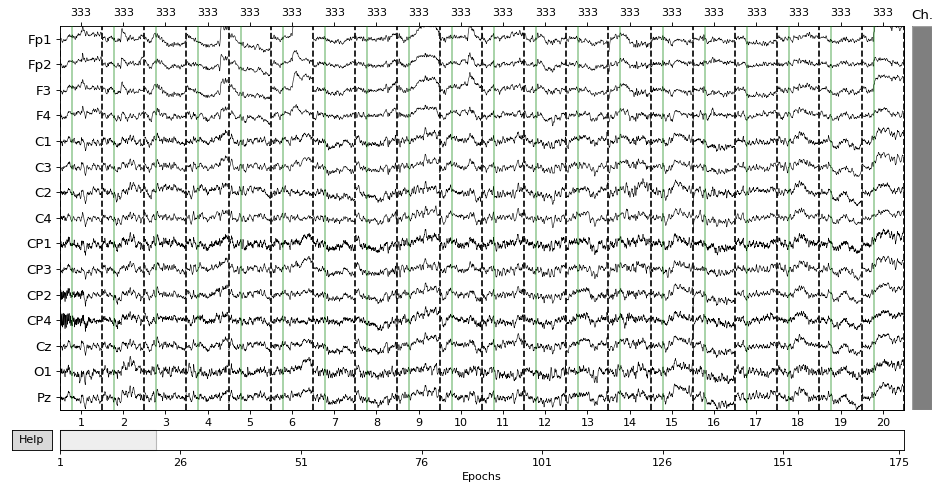

In [18]:
reject_criteria = dict(eeg = 1.3e-4)

epochs = mne.Epochs(raw_1020, events, event_id = 333, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

fig = epochs.plot(scalings=0.5e-4, block=True)

Notice the difference between _time_ and _epochs_.

175 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


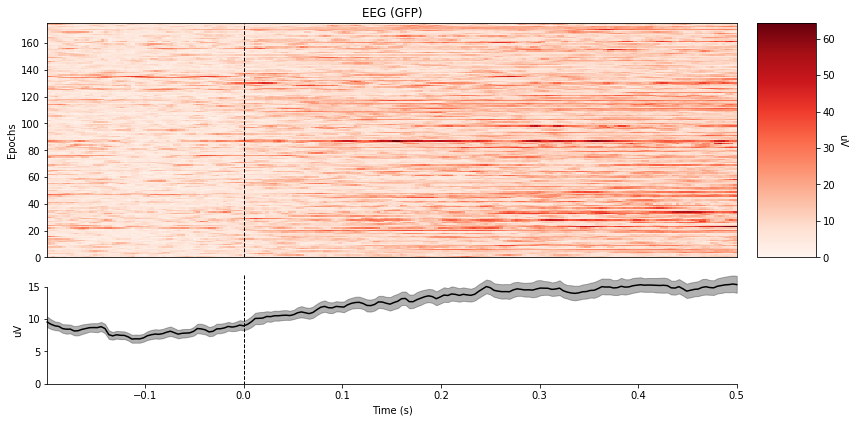

[<Figure size 864x432 with 3 Axes>]

In [19]:
epochs.plot_image()

For blinks and heartbeat, EOG and ECG channels are needed. The former is the only one we will care about in EEG.

## Subtract pre-stimulus baseline

If we had any stimulus recorded, it would be helpfull for analysis to subtract any noise before the stimulus trigger. This is not the case.

## Trial Rejection

This can be done both manually or automatically. There is no agreement in the literature.

We have already computed automatic trial rejection when epoching data, based on signal amplitud.

Manually, we can add _bad lables_ to be ignored when analysing (only for interactive plotting).

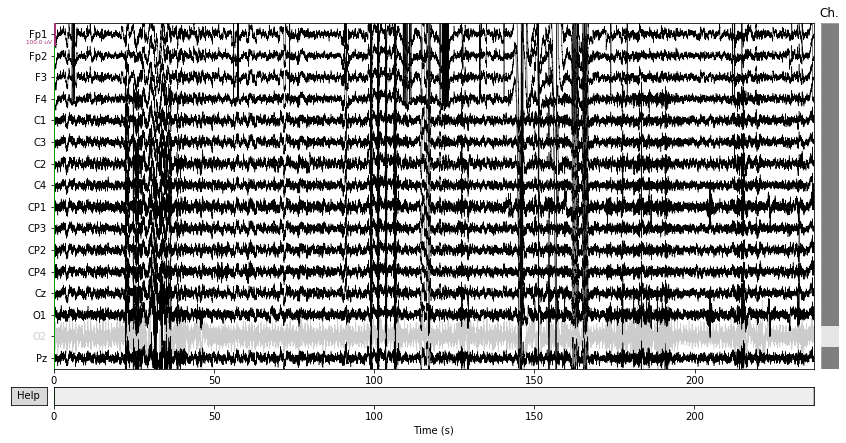

/Users/Pablo/Desktop/Virtualenv/lib/python3.7/site-packages/mne/viz/utils.py:110: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


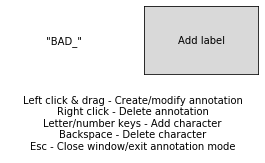

In [20]:
timeEEG = raw_1020.plot(start = 0., duration = 250., scalings=0.5e-4, remove_dc=True)
timeEEG.canvas.key_press_event('a')

### Blinks

The following line is **intended to give an error**, because no EOG channels found, but it's an example of how to remove them using MNE.

In [21]:
eog_events = mne.preprocessing.find_eog_events(raw_1020)
onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ['bad blink'] * len(eog_events)
blink_annot = mne.Annotations(onsets, durations, descriptions,
                              orig_time=raw_1020.info['meas_date'])
raw_1020.set_annotations(blink_annot)

No EOG channels found
Trying with EEG 061 and EEG 062


RuntimeError: EEG 61 or EEG 62 channel not found !!

## Further preprocessing

As suggested by [Cohen](https://www.youtube.com/watch?v=JMB9nZNGVyk) we will perform `ICA` and further preprocessing in a separated script. 

Thus, this notebook summarizes the very first steps in preprocessing.

Fitting ICA to data using 15 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 0.3s.


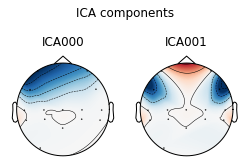

IndexError: list index out of range

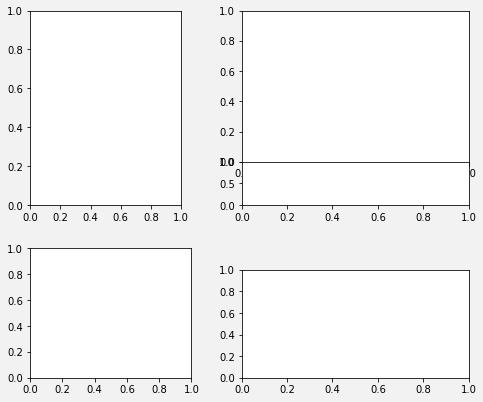

In [24]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=2, random_state=97, max_iter=8)
ica.fit(raw_1020)

ica.plot_components()

ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw_1020, picks=[0, 1])